### Homework: Implement possibilistic k-means

Goal:
1. Implement the mahalanobis_distance function.
2. Implement the calculate_eta function.
3. Implement the calculate_u.

Hint: the assignation matrix should not be set to zeros at the beginning.

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
import sklearn.datasets as ds

In [2]:
#funtion to calculate eta
def calculate_eta(U, distance_matrix):
    eta = np.sum(U * distance_matrix, axis=1) / np.sum(U, axis=1)
    return eta

In [3]:
#funtion to calculate centers
def calculate_clusters(data, U, fuzz):
    um = U ** fuzz
    centers = um.dot(data.T) / np.atleast_2d(um.sum(axis=1)).T
    return centers

In [4]:
#function to calculate distance
def mahalanobis_distance(a, b):
    return cdist(a, b, 'mahalanobis')

In [5]:
def calculate_U(data, centers, n, m):
    #possiblistic

    lenght = mahalanobis_distance(data.T, centers)
    lenght = np.fmax(lenght, np.finfo(data.dtype).eps)

    val = ((lenght ** 2) / n).T ** (1. / (m - 1))
    U = 1. / (1. + val)

    return U, lenght

In [6]:
def init_U(data, centers, n, m):
    #fuzzy
    
    lenght = mahalanobis_distance(data.T, centers).T
    lenght = np.fmax(lenght, np.finfo(data.dtype).eps)

    val = lenght ** (-2. / (m - 1))
    U = val / np.sum(val, axis=0, keepdims=1)

    return U, lenght

In [7]:
def kmeans(data, cluster_number, fuzz, error, max_iterations, function, centers0=None, n=None):
    
    S, N = data.shape

    centers = np.empty((max_iterations, cluster_number, S))
    centers[0] = np.array(centers0)

    U = np.empty((max_iterations, cluster_number, N))

    i = 0
    while i < max_iterations - 1:

        U[i], distance = function(data, centers[i], n, fuzz)
        centers[i + 1] = calculate_clusters(data, U[i], fuzz)

        #stop condition
        if np.linalg.norm(centers[i + 1] - centers[i]) < error:
            break

        i += 1
    return centers[i], centers[0], U[i - 1], U[0], distance, i
    #return:
    #1. last Centers matrix
    #2. first Centers matrix
    #3. last U matrix
    #4. first U matrix
    #5. distance matrix
    #6. current iteration


In [8]:
def calculate(data, cluster_number, fuzz, error, max_iterations, centers0=None):
    
    if centers0 is None:
        xt = data.T
        centers0 = xt[np.random.choice(xt.shape[0], cluster_number, replace=False), :]

    centers, centers0, U, u0, distance, t = kmeans(data, cluster_number, fuzz, error, max_iterations, init_U, centers0, fuzz)
    n = calculate_eta(U, distance)
    return kmeans(data, cluster_number, fuzz, error, t, calculate_U, centers0=centers, n=n)

In [9]:
def plot(x, centers, u, c, labels=None):

    ax = plt.subplots()[1]

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)

    for j in range(c):
        ax.scatter( x[0][cluster_membership == j],
            x[1][cluster_membership == j],
            alpha=0.5,
            edgecolors="none")

    # Mark the center of each fuzzy cluster
    for pt in centers:
        ax.plot(pt[0], pt[1], 'rs')

    ax.legend()
    ax.grid(True)
    plt.show()
   

No handles with labels found to put in legend.


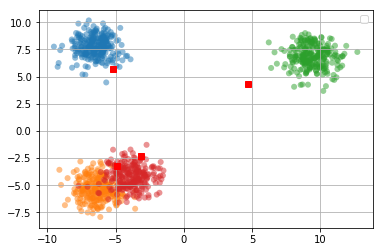

In [10]:
num_samples = 1000
num_features = 4
cluster_number = 4
fuzzifier = 2
error = 0.001
maxiter = 100

#creating data for clustering
sample_data = ds.make_blobs(num_samples, num_features, cluster_number)[0]
np.random.shuffle(sample_data)
sample_data = sample_data.T

#calculati
centers, centers0, U, U0, d, t = calculate(sample_data, cluster_number, fuzzifier, error, maxiter)

plot(sample_data, centers, U, cluster_number)